In [64]:
from astropy.io import fits
import reproject
from astropy import convolution
from astropy.convolution import Gaussian2DKernel
from astropy import units as u
from astropy.table import Table
import pyavm
import shutil

In [65]:
import regions
from astropy import coordinates

In [66]:
import PIL

In [67]:
from spectral_cube import SpectralCube, Projection, Slice

In [68]:
import uvcombine
from astropy import wcs

In [69]:
import scipy.ndimage

In [70]:
import matplotlib
from matplotlib.colors import rgb_to_hsv, hsv_to_rgb

In [71]:
import numpy as np

In [72]:
import pylab as pl
from astropy.visualization import simple_norm

In [73]:
import warnings
warnings.filterwarnings('ignore')

In [74]:
basepath = '/orange/adamginsburg/jwst/brick/'
image_filenames = {
"f182m": f"{basepath}/F182M/pipeline/jw02221-o001_t001_nircam_clear-f182m-merged-reproject_i2d.fits",
"f187n": f"{basepath}/F187N/pipeline/jw02221-o001_t001_nircam_clear-f187n-merged-reproject_i2d.fits",
"f212n": f"{basepath}/F212N/pipeline/jw02221-o001_t001_nircam_clear-f212n-merged-reproject_i2d.fits",
}
repr212_image_filenames = {x: y.replace("i2d", "i2d_reprj_f212") if x != 'f212n' else y for x,y in image_filenames.items()}

In [75]:
tgt_header = fits.getheader(image_filenames['f212n'], ext=('SCI', 1))
wcs.WCS(tgt_header)

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 266.5355026705 -28.713135673174 
CRPIX : 2484.6907322601 5878.3480524462 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -8.5391104898054e-06 8.5391104898054e-06 
NAXIS : 4945  11772

In [76]:
for filtername in image_filenames:
    if not os.path.exists(repr212_image_filenames[filtername]):
        print(f"Reprojecting {filtername} {image_filenames[filtername]} to {repr212_image_filenames[filtername]}")
        result,_ = reproject.reproject_interp(image_filenames[filtername], tgt_header, hdu_in='SCI')
        hdu = fits.PrimaryHDU(data=result, header=tgt_header)
        hdu.writeto(repr212_image_filenames[filtername], overwrite=True)

In [77]:
rgb3 = np.array(
      [
          fits.getdata(repr212_image_filenames['f212n']),
          fits.getdata(repr212_image_filenames['f187n']),
          fits.getdata(repr212_image_filenames['f182m']),
      ]
).swapaxes(0,2)
rgb3.shape

(4945, 11772, 3)

In [78]:
AVM = pyavm.AVM.from_header(tgt_header)
AVM.to_wcs().to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      2484.6907322601 / Pixel coordinate of reference point            
CRPIX2  =      5878.3480524462 / Pixel coordinate of reference point            
CDELT1  = -8.5391104898054E-06 / [deg] Coordinate increment at reference point  
CDELT2  =  8.5391104898054E-06 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =       266.5355026705 / [deg] Coordinate value at reference point      
CRVAL2  =     -28.713135673174 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =     -28.7131356731

In [79]:
def save_rgb(img, filename, avm=None, flip=-1):
    img = (img*256)
    img[img<0] = 0
    img[img>255] = 255
    img = img.astype('uint8')
    img = PIL.Image.fromarray(img[::flip,:,:])
    img.save(filename)
    if avm is not None:
        base = os.path.basename(filename)
        dir = os.path.dirname(filename)
        avmname = os.path.join(dir, 'avm_'+base)
        avm.embed(filename, avmname)
        shutil.move(avmname, filename)
    return img

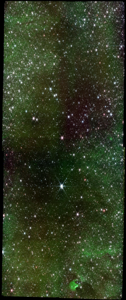

In [80]:
rgb_scaled = np.array([simple_norm(rgb3[:,:,0], stretch='asinh', min_percent=1, max_percent=99.)(rgb3[:,:,0]),
                       simple_norm(rgb3[:,:,1], stretch='asinh', min_percent=1, max_percent=99.)(rgb3[:,:,1]),
                       simple_norm(rgb3[:,:,2], stretch='asinh', min_percent=1, max_percent=99.)(rgb3[:,:,2])]).swapaxes(0,2)
im = save_rgb(rgb_scaled, f"{basepath}/images/BrickJWST_212-187-182_RGB_unrotated.png", AVM)
im.thumbnail((300,300))
im

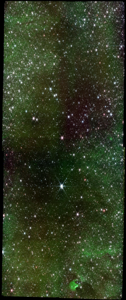

In [81]:
im = PIL.Image.open(f"{basepath}/images/BrickJWST_212-187-182_RGB_unrotated.png")
im.thumbnail((300,300))
im

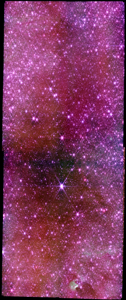

In [82]:
rgb_scaled = np.array([simple_norm(rgb3[:,:,0], stretch='asinh', min_percent=1, max_percent=95.)(rgb3[:,:,0]),
                       simple_norm(rgb3[:,:,1], stretch='asinh', min_percent=1, max_percent=99.)(rgb3[:,:,1]),
                       simple_norm(rgb3[:,:,2], stretch='asinh', min_percent=1, max_percent=95.)(rgb3[:,:,2])]).swapaxes(0,2)
im = save_rgb(rgb_scaled, f"{basepath}/images/BrickJWST_212-187-182_RGB_unrotated_2.png", AVM)
im.thumbnail((300,300))
im

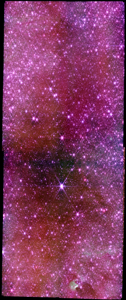

In [83]:
im = PIL.Image.open(f"{basepath}/images/BrickJWST_212-187-182_RGB_unrotated_2.png")
im.thumbnail((300,300))
im

In [84]:
pyavm.AVM.from_image(f'{basepath}/images/BrickJWST_212-187-182_RGB_unrotated.png').to_wcs().to_header()

WCSAXES =                    2 / Number of coordinate axes                      
CRPIX1  =      2484.6907322601 / Pixel coordinate of reference point            
CRPIX2  =      5878.3480524462 / Pixel coordinate of reference point            
CDELT1  =    -8.5391104898E-06 / [deg] Coordinate increment at reference point  
CDELT2  =     8.5391104898E-06 / [deg] Coordinate increment at reference point  
CUNIT1  = 'deg'                / Units of coordinate increment and value        
CUNIT2  = 'deg'                / Units of coordinate increment and value        
CTYPE1  = 'RA---TAN'           / Right ascension, gnomonic projection           
CTYPE2  = 'DEC--TAN'           / Declination, gnomonic projection               
CRVAL1  =       266.5355026705 / [deg] Coordinate value at reference point      
CRVAL2  =     -28.713135673174 / [deg] Coordinate value at reference point      
LONPOLE =                180.0 / [deg] Native longitude of celestial pole       
LATPOLE =     -28.7131356731